Jonathan Hobbs

# Trust me, I'm from the government

The Wellcome Global Monitor is a large study into attitudes towards health and science. In 2018, the first of these studies was carried out in over 140 countries with over 140,000 respondents. The findings are far-reaching and can be found, with more information about the study, at https://wellcome.ac.uk/reports/wellcome-global-monitor/2018. 

The data is also publicly available from the same website. This analysis uses the data, with a focus on a few specific questions asked in the survey and respondents from the UK only. In particular, it is concerned with levels of trust in medical advice from medical workers and from government among the UK population.

Among the several advantages of using this data are that responses have already been coded for ready analysis and survey features like weightings are available. To make it easier to use, only UK respondents were copied from the data file into another file (named 'wgm_2018_uk.csv'), so that it contains just the 1,000 responses under investigation.

This analysis begins with importing the required Python libraries and this data. Next, the data is inspected broadly and also prepared for analysis. Overall levels of trust will be assessed. Then, different demographic variables are interrogated, first individually and then in a multivariate model, to find which of them might affect trust levels. The model will then be used to pinpoint where there might be target groups in terms of winning trust. Finally, some discussion will follow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

In [2]:
df = pd.read_csv('wgm_2018_uk.csv')
df.head()

,WP5,wgt,PROJWT,FIELD_DATE,YEAR_CALENDAR,Q1,Q2,Q3,Q4,Q5A,...,Age,AgeCategories,Gender,Education,Urban_Rural,Household_Income,Regions_Report,Subjective_Income,WBI,EMP_2010
0,12,0.660212,35676.829222,5/1/2018,2018,3,3,1,2,1,...,61,3,2,1,2,2,15,2,4,2
1,12,1.454006,78572.191694,5/1/2018,2018,1,1,2,2,1,...,41,2,1,2,2,2,15,2,4,1
2,12,0.305742,16521.821242,5/1/2018,2018,2,3,98,98,2,...,28,1,1,3,2,3,15,3,4,3
3,12,0.611130,33024.522413,5/1/2018,2018,4,2,1,2,1,...,32,2,1,3,2,5,15,1,4,1
4,12,0.793783,42894.795054,5/1/2018,2018,2,1,1,2,1,...,23,1,1,3,2,1,15,2,4,1


# Assessing levels of trust in medical advice

One of the primary subjects of the Wellcome Global Monitor, and the focus of this analysis, is trust. The WGM survey asks about general trust in neighbourhoods, national governments, scientists, journalists, doctors and nurses, NGOs and traditional healers (Q11A - Q11G) and also specifically trust in the medical advice from governments and from medical workers (Q21 & Q22). Possible responses to these questions are:

1: A lot, 2: Some, 3: Not much, 4: Not at all, 98: Don't know, 99: Refused to answer

The aim of this analysis is specifically to look at trust levels in government and medical workers, both in general and for medical advice. For brevity, it will refer to 'doctors and nurses' and 'medical workers' generally as 'medics'.

The WGM has two ready-made weightings attached to each respondent. wgt is referred to as 'National weight, for analaysis at the country level', in which the total weight for all 1000 respondents in each country is 1000. This will be used to give some extra accuracy to frequencies. There is also PROJWT which gives a total weight of the country's population of over 15s, for global analysis. 

In [3]:
labels = ['A lot', 'Some', 'Not much', 'Not at all', 'DK', 'Refused']
questions = ["Govt. in general", "Medics in general", "Govt. medical advice", "Medics medical advice"]
gov_gen = (df.groupby('Q11B').wgt.sum()/10).reset_index()
med_gen = (df.groupby('Q11E').wgt.sum()/10).reset_index()
gov_med = (df.groupby('Q21').wgt.sum()/10).reset_index()
med_med = (df.groupby('Q22').wgt.sum()/10).reset_index()
population = pd.DataFrame([gov_gen.wgt, med_gen.wgt, gov_med.wgt, med_med.wgt], index=questions)
population.columns = labels
population

,A lot,Some,Not much,Not at all,DK,Refused
Govt. in general,11.717565,39.305267,24.411466,22.956656,1.112096,0.496949
Medics in general,65.969278,26.797045,5.050286,1.727899,0.309871,0.145621
Govt. medical advice,41.421126,40.062159,14.648688,2.934712,0.717004,0.216311
Medics medical advice,66.011911,26.259947,4.386455,2.789407,0.479579,0.072700


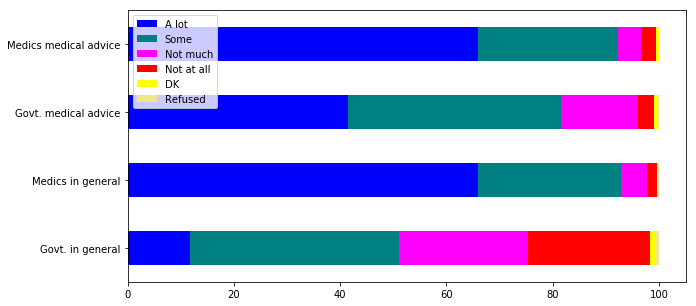

In [4]:
colors = [ 'blue', 'teal', 'magenta', 'red', 'yellow', 'khaki']
fig, ax = plt.subplots(figsize=(10,5))
population.plot.barh(stacked=True, ax=ax, color=colors)

It is clear that trust in medics is higher than in governments, both in general and for medical advice. In fact, trust in medics is very high, with over 90% saying they trust them 'A lot' or 'Some' for both questions.

It also appears that trust in medical advice from governments is higher than general trust in them, but it is still lower than trust in medics.

In [5]:
def trust_diff(a, b):
    if a<5 and b<5:
        return a - b
    else:
        return
print("Comparative general trust in governments vs medics")    
df['med_v_gov_gen'] = df.apply(lambda row: trust_diff(row['Q11E'], row['Q11B']), axis=1)
print(df.groupby('med_v_gov_gen').wgt.sum()/10)
print("Comparative trust in medical advice from governments vs medics")
df['med_v_gov'] = df.apply(lambda row: trust_diff(row['Q22'], row['Q21']), axis=1)
print(df.groupby('med_v_gov').wgt.sum()/10)

Comparative general trust in governments vs medics
med_v_gov_gen
-3.0    14.073595
-2.0    20.833767
-1.0    36.104374
 0.0    21.747365
 1.0     4.582433
 2.0     0.593929
Name: wgt, dtype: float64
Comparative trust in medical advice from governments vs medics
med_v_gov
-3.0     1.180485
-2.0     6.243597
-1.0    25.108530
 0.0    59.989190
 1.0     5.939287
 2.0     0.277366
Name: wgt, dtype: float64


There are few people who trust government more medics, around 6% both in general and for medical advice. In contrast, around 70% trust medics more than government in general. Around 30% trust medical advice from medics more than from government.

As well as looking at the frequencies/percentages for each response, it is possible to assign a 'Score' to each question which is a weighted average response with weightings of (3, 2, 1, 0) respectively for the responses (excluding DK and Refused). This is an arbitrary score, but can be used for a more straightforward comparison. It has a maximum of 3 (everyone answered, 'A lot') and a minimum of 0 (everyone answered, 'Not at all', 'Don't know' or Refused to answer).

Supplementary to this, the Gini impurity describes the distribution of responses, where a lower score means responses were more uniform and vice versa. The simplified formula for the Gini impurity, where J is the number of classes and pi is the probability of selecting that class is:

<img src="gini_impurity.png">

In [6]:
scoring = np.array([0.03, 0.02, 0.01, 0])
def gini_imp(response):
    imp = 1
    for i in range(4):
        imp -= (response[i]**2*0.0001)
    return imp

population['Score'] = population.apply(lambda row: row[:4].dot(scoring), axis=1)
population['Gini impurity'] = population.apply(lambda row: gini_imp(row), axis=1)
population

,A lot,Some,Not much,Not at all,DK,Refused,Score,Gini impurity
Govt. in general,11.717565,39.305267,24.411466,22.956656,1.112096,0.496949,1.381747,0.719487
Medics in general,65.969278,26.797045,5.050286,1.727899,0.309871,0.145621,2.565522,0.490148
Govt. medical advice,41.421126,40.062159,14.648688,2.934712,0.717004,0.216311,2.190364,0.645612
Medics medical advice,66.011911,26.259947,4.386455,2.789407,0.479579,0.072700,2.549421,0.492582


The scores corresponds to what we have already seen. The Gini impurities reveal that there is higher variation in trust in the government but more uniform trust in medics.

# How trust varies between demographic groups

Since there is little distrust in medics in this country, it would be difficult to find any meaningful conclusions by further exploring this data. Therefore, this analysis will investigate trust levels in the government. Specifically, it will seek to answer to some degree how trust in government medical advice differs among groups. 

Before attempting to derive any answers to this question, it is useful to look at what these groups might be. The WGM records various interesting demographic characteristics. These include whether the respondent is religious, their age, gender, education level, whether they live in an urban or rural area, income, subjective income and employment status. (These are some of the features used by the WGM to calculate weightings.)

Note on income:
Although respondents were asked to give eiter their total household income or a range within which their income lies (eg. £15k or £10k-20k) this is not recorded in the dataset. Instead, this was converted to per capita income and then classified in sample quintiles. As such, it is not possible to know exactly what these ranges were. 

Using data from ONS on disposable (after direct tax) household income per capita, approximate quintile boundaries are: 

£17.6k, £24.0k, £31.1k, £41.9k

https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/bulletins/householddisposableincomeandinequality/yearending2018

In [7]:
religion = (df.groupby('D1').wgt.sum()/10)
print(religion.rename(index={1: 'Religious', 2: 'Non religious', 99: 'DK/Refused'}))
age = (df.groupby('AgeCategories').wgt.sum()/10)[1:]
print(age.rename(index={'1': '15 to 29', '2': '30 to 49', '3': '50+'}))
gender = (df.groupby('Gender').wgt.sum()/10)
print(gender.rename(index={1: 'Male', 2: 'Female'}))
ed = (df.groupby('Education').wgt.sum()/10)[1:]
print(ed.rename(index={'1': 'Primary', '2': 'Secondary', '3': 'Tertiary'}))
area = (df.groupby('Urban_Rural').wgt.sum()/10)[1:]
print(area.rename(index={'1': 'Urban', '2': 'Rural'}))
quint = (df.groupby('Household_Income').wgt.sum()/10)
print(quint.rename(index={1: 'Poorest 20%', 2: 'Second 20%', 3: 'Third 20%', 4: 'Fourth 20%', 5: 'Richest 20%'}))
finance = (df.groupby('Subjective_Income').wgt.sum()/10)[1:]
print(finance.rename(index={'1': 'Living comfortably on income', '2': 'Getting by on income', '3': 'Finding it hard on income'}))
employment = (df.groupby('EMP_2010').wgt.sum()/10)
print(employment.rename(index={1: 'Full-time Employed', 2: 'Full-time Self-employed', 3: 'Part-time Employed', 4:'Unemployed', 5: 'Part-time Employed (wants Full-time)', 6: 'Out of Workforce'}))

D1
Religious        68.835374
Non religious    28.765642
DK/Refused        2.398984
Name: wgt, dtype: float64
AgeCategories
15 to 29    22.191376
30 to 49    32.226470
50+         44.681257
Name: wgt, dtype: float64
Gender
Male      48.285265
Female    51.714735
Name: wgt, dtype: float64
Education
Primary      16.117429
Secondary    53.636119
Tertiary     29.046842
Name: wgt, dtype: float64
Urban_Rural
Urban    55.632125
Rural    44.111090
Name: wgt, dtype: float64
Household_Income
Poorest 20%    19.894726
Second 20%     20.059787
Third 20%      20.039719
Fourth 20%     19.979256
Richest 20%    20.026512
Name: wgt, dtype: float64
Subjective_Income
Living comfortably on income    40.891318
Getting by on income            41.773890
Finding it hard on income       16.105889
Name: wgt, dtype: float64
EMP_2010
Full-time Employed                      36.461935
Full-time Self-employed                  7.856742
Part-time Employed                       8.141927
Unemployed                       

Assuming the survey has been weighted accurately, these frequencies should reflect the UK (15+) population, and this appears to be the case (the WGM documentation states there is a +/- 3.63% margin of error for the UK sample).

The UK demographic is diverse in terms of all of the above features. Therefore, it will be useful to interrogate each of them to see which have a significant effect on trust in government medical advice. A Chi-squared test can be done for each feature to see if the distribution of responses was significantly different between subsets. A p-value of <0.05 is taken to be indicative of a significant difference.

In [8]:
religion_trust = (df.groupby(['D1', 'Q21']).wgt.sum()).reset_index()
religion_trust = religion_trust.pivot(columns='Q21', index='D1', values='wgt')
religion_trust = religion_trust.iloc[[0,1],[0,1,2,3]]
stat, p, dof, ex = chi2_contingency(religion_trust)
print("Religion")
print(p)

age_trust = (df.groupby(['AgeCategories', 'Q21']).wgt.sum()).reset_index()
age_trust = age_trust.pivot(columns='Q21', index='AgeCategories', values='wgt')
age_trust = age_trust.iloc[[1,2,3],[0,1,2,3]]
stat, p, dof, ex = chi2_contingency(age_trust)
print("Age")
print(p)

gender_trust = (df.groupby(['Gender', 'Q21']).wgt.sum()).reset_index()
gender_trust = gender_trust.pivot(columns='Q21', index='Gender', values='wgt')
gender_trust = gender_trust.iloc[[0,1],[0,1,2,3]]
stat, p, dof, ex = chi2_contingency(gender_trust)
print("Gender")
print(p)

education_trust = (df.groupby(['Education', 'Q21']).wgt.sum()).reset_index()
education_trust = education_trust.pivot(columns='Q21', index='Education', values='wgt')
education_trust = education_trust.iloc[[1,2,3],[0,1,2,3]]
stat, p, dof, ex = chi2_contingency(education_trust)
print("Education")
print(p)

area_trust = (df.groupby(['Urban_Rural', 'Q21']).wgt.sum()).reset_index()
area_trust = area_trust.pivot(columns='Q21', index='Urban_Rural', values='wgt')
area_trust = area_trust.iloc[[1,2],[0,1,2,3]]
stat, p, dof, ex = chi2_contingency(area_trust)
print("Urban/Rural")
print(p)

quint_trust = (df.groupby(['Household_Income', 'Q21']).wgt.sum()).reset_index()
quint_trust = quint_trust.pivot(columns='Q21', index='Household_Income', values='wgt')
quint_trust = quint_trust.iloc[[0,1,2,3,4],[0,1,2,3]]
stat, p, dof, ex = chi2_contingency(quint_trust)
print("Household income")
print(p)

finance_trust = (df.groupby(['Subjective_Income', 'Q21']).wgt.sum()).reset_index()
finance_trust = finance_trust.pivot(columns='Q21', index='Subjective_Income', values='wgt')
finance_trust = finance_trust.iloc[[1,2,3],[0,1,2,3]]
stat, p, dof, ex = chi2_contingency(finance_trust)
print("Subjective income")
print(p)

emp_trust = (df.groupby(['EMP_2010', 'Q21']).wgt.sum()).reset_index()
emp_trust = emp_trust.pivot(columns='Q21', index='EMP_2010', values='wgt')
emp_trust = emp_trust.iloc[[0,1,2,3,4,5],[0,1,2,3]]
stat, p, dof, ex = chi2_contingency(emp_trust)
print("Employment status")
print(p)

Religion
0.20941816452882592
Age
0.011676777552249768
Gender
0.30543357201234295
Education
0.42717200090150476
Urban/Rural
0.7316684196913086
Household income
0.0040296966526362134
Subjective income
1.8557781410199313e-07
Employment status
4.1737248918632096e-05


The features with a statistically significant effect are Age categories, Household income quintiles, Subjective income categories and Employment status. The effect appears to be particularly strong for the latter 2 features.

Before continuing, it would be useful to see whether there is a strong relationship between actual household income and subjective income. This could also be done using a statistical independence test but a more visual way would be to compare the numbers in each of the 15 possible combinations.

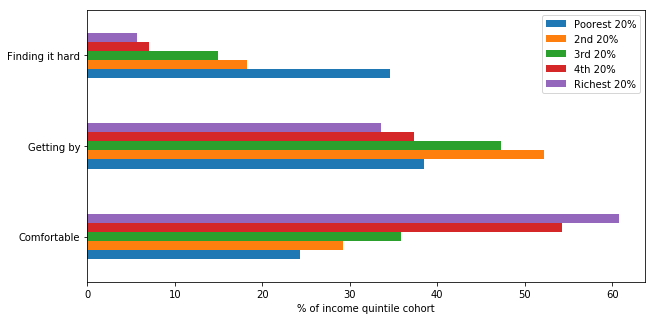

In [9]:
quintile = [1,2,3,4,5]
quintvsubj = pd.DataFrame()
for q in quintile:
    subjective = df[df['Household_Income']==q].groupby('Subjective_Income').wgt.sum().loc[['1','2','3']]/quint[q]*10
    quintvsubj[q] = subjective
fig1, ax1 = plt.subplots(figsize=(10,5))
quintvsubj.plot.barh(stacked=False, ax=ax1)
ax1.set_xlabel('% of income quintile cohort')
ax1.set_ylabel('')
ax1.set_yticklabels(['Comfortable', 'Getting by', 'Finding it hard'])
ax1.legend(['Poorest 20%', '2nd 20%', '3rd 20%', '4th 20%', 'Richest 20%'])

If the two reponses were related it would be expected to see very high percentages 'finding it hard' in the poorest quintiles and very high percentages 'comfortable' in the richest. This is the case to an extent, especially with the richest quintile. However, perhaps surprisingly, those in the poorest quintile are relatively evenly split between the three subjective categories. Generally, there are few who admit to 'finding it hard' on their income. As such, there appears to be enough independence between the categories to keep both of them for analaysis.

In [10]:
labels_short = ['A lot', 'Some', 'Not much', 'Not at all']

age_trust_p = (df.groupby(['AgeCategories', 'Q21']).wgt.sum()/df.groupby('AgeCategories').wgt.sum()*100).reset_index()
age_trust_p = age_trust_p.pivot(columns='Q21', index='AgeCategories', values='wgt')
age_trust_p = age_trust_p.iloc[[1,2,3],[0,1,2,3]].rename(index={'1': '15 to 29', '2': '30 to 49', '3': '50+'}, columns={1: 'A lot', 2: 'Some', 3: 'Not much', 4: 'Not at all'})
age_trust_p['Score'] = age_trust_p.apply(lambda row: row[:4].dot(scoring), axis=1)
age_trust_p['Gini impurity'] = age_trust_p.apply(lambda row: gini_imp(row), axis=1)

quint_trust_p = (df.groupby(['Household_Income', 'Q21']).wgt.sum()/df.groupby(['Household_Income']).wgt.sum()*100).reset_index()
quint_trust_p = quint_trust_p.pivot(columns='Q21', index='Household_Income', values='wgt')
quint_trust_p = quint_trust_p.iloc[[0,1,2,3,4],[0,1,2,3]].rename(index={1: 'Poorest 20%', 2: 'Second 20%', 3: 'Third 20%', 4: 'Fourth 20%', 5: 'Richest 20%'}, columns={1: 'A lot', 2: 'Some', 3: 'Not much', 4: 'Not at all'})
quint_trust_p['Score'] = quint_trust_p.apply(lambda row: row[:4].dot(scoring), axis=1)
quint_trust_p['Gini impurity'] = quint_trust_p.apply(lambda row: gini_imp(row), axis=1)

finance_trust_p = (df.groupby(['Subjective_Income', 'Q21']).wgt.sum()/df.groupby(['Subjective_Income']).wgt.sum()*100).reset_index()
finance_trust_p = finance_trust_p.pivot(columns='Q21', index='Subjective_Income', values='wgt')
finance_trust_p = finance_trust_p.iloc[[1,2,3],[0,1,2,3]].rename(index={'1': 'Living comfortably on income', '2': 'Getting by on income', '3': 'Finding it hard on income'}, columns={1: 'A lot', 2: 'Some', 3: 'Not much', 4: 'Not at all'})
finance_trust_p['Score'] = finance_trust_p.apply(lambda row: row[:4].dot(scoring), axis=1)
finance_trust_p['Gini impurity'] = finance_trust_p.apply(lambda row: gini_imp(row), axis=1)

emp_trust_p = (df.groupby(['EMP_2010', 'Q21']).wgt.sum()/df.groupby(['EMP_2010']).wgt.sum()*100).reset_index()
emp_trust_p = emp_trust_p.pivot(columns='Q21', index='EMP_2010', values='wgt')
emp_trust_p = emp_trust_p.iloc[[0,1,2,3,4,5],[0,1,2,3]].rename(index={1: 'Full-time Employed', 2: 'Full-time Self-employed', 3: 'Part-time Employed (1)', 4:'Unemployed', 5: 'Part-time Employed (2)', 6: 'Out of Workforce'}, columns={1: 'A lot', 2: 'Some', 3: 'Not much', 4: 'Not at all'})
emp_trust_p['Score'] = emp_trust_p.apply(lambda row: row[:4].dot(scoring), axis=1)
emp_trust_p['Gini impurity'] = emp_trust_p.apply(lambda row: gini_imp(row), axis=1)

print(age_trust_p[['Score', 'Gini impurity']])
print(quint_trust_p[['Score', 'Gini impurity']])
print(finance_trust_p[['Score', 'Gini impurity']])
print(emp_trust_p[['Score', 'Gini impurity']])
print("(1) Does not want full-time. (2) Wants full-time.")

Q21               Score  Gini impurity
AgeCategories                         
15 to 29       2.243260       0.633396
30 to 49       2.180024       0.646905
50+            2.165354       0.649799
Q21                  Score  Gini impurity
Household_Income                         
Poorest 20%       2.016451       0.683058
Second 20%        2.217473       0.647214
Third 20%         2.234795       0.619163
Fourth 20%        2.218745       0.641614
Richest 20%       2.263203       0.609201
Q21                              Score  Gini impurity
Subjective_Income                                    
Living comfortably on income  2.326987       0.604317
Getting by on income          2.187308       0.642795
Finding it hard on income     1.862350       0.690167
Q21                         Score  Gini impurity
EMP_2010                                        
Full-time Employed       2.225430       0.634465
Full-time Self-employed  2.065675       0.662213
Part-time Employed (1)   2.162145       0.649

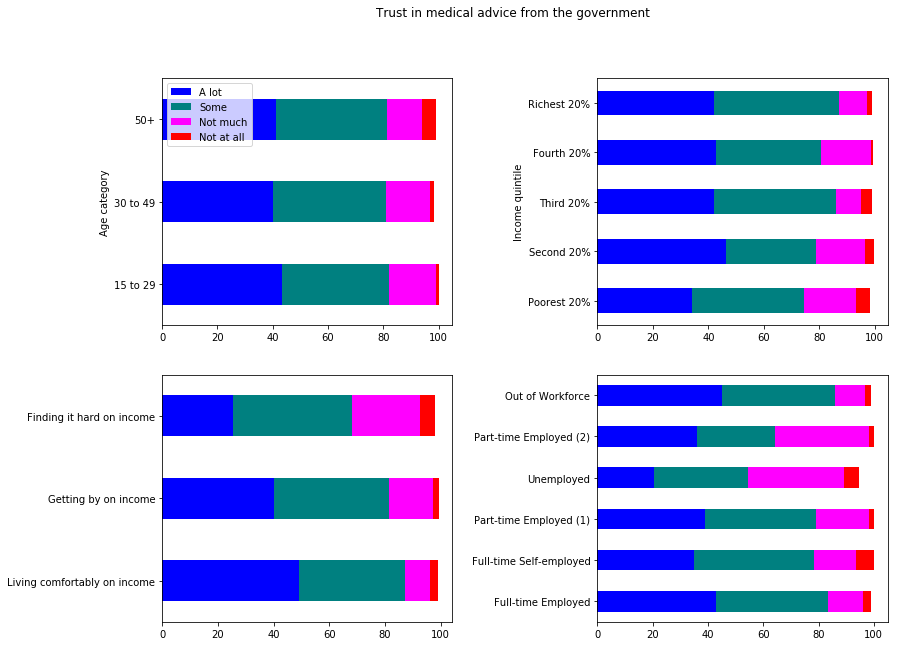

In [11]:
fig2, ax2 = plt.subplots(2,2,figsize=(13,10))
fig2.suptitle("Trust in medical advice from the government")
age_trust_p[['A lot', 'Some', 'Not much', 'Not at all']].plot.barh(stacked=True, color=colors, ax=ax2[0,0], legend=False)
ax2[0,0].set_ylabel("Age category")
quint_trust_p[['A lot', 'Some', 'Not much', 'Not at all']].plot.barh(stacked=True, color=colors, ax=ax2[0,1], legend=False)
ax2[0,1].set_ylabel("Income quintile")
finance_trust_p[['A lot', 'Some', 'Not much', 'Not at all']].plot.barh(stacked=True, color=colors, ax=ax2[1,0], legend=False)
ax2[1,0].set_ylabel(None)
emp_trust_p[['A lot', 'Some', 'Not much', 'Not at all']].plot.barh(stacked=True, color=colors, ax=ax2[1,1], legend=False)
ax2[1,1].set_ylabel(None)
ax2[0,0].legend()
fig2.subplots_adjust(wspace=0.5)
plt.savefig('trust_demographics.png')

In terms of single features, the groups with the lowest trust in government medical advice are the unemployed (Trust score of 1.64), those in part-time employment but wanting full-time (Trust score of 1.99) and those who say that they are finding it hard to get by on their current income (Trust score of 1.86). As stated above, the Trust score for the whole population is 2.19. It should be noted that these low trust scores are accompanied by higher Gini impurities. This can also be seen in the graphs.

Three groups in particular appear to have more trust - those out of the workforce (Trust score of 2.28), those who say that they are living comfortably on their income (Trust score of 2.33) and those in the richest 20% of actual household income per capita (Trust score of 2.26). Incidentally, these groups also have the lowest Gini impurities, meaning they are more uniformly trusting.

# Multiple feature modelling

It is unlikely that each feature acts independently, so it is useful to build a multi-dimensional model to see how they might interact. Since the dependent variable (trust in medical advice from government) is categorical, rather than continuous, a logistic regression classifier is more appropriate than other methods. 

The data needs to be refined so that the logistic regression is possible. First, it is convenient to remove missing or incomplete values and, for this analysis, only respondents with valid responses to all of the appropriate questions are allowed.

In [12]:
features = df[['Q21', 'AgeCategories', 'Household_Income', 'Subjective_Income', 'EMP_2010']]
features = features.apply(pd.to_numeric, errors='coerce').dropna()
features = features[(features < 90).all(1)]
print(features.shape)

(974, 5)


26 respondents were removed due for Don't Know, Refused or missing responses.

Next, the responses need to be converted to binary dummy variables.

In [13]:
X = pd.DataFrame()
X['Age1'] = features.apply(lambda row: 1 if row['AgeCategories'] == 1 else 0, axis=1)
X['Age2'] = features.apply(lambda row: 1 if row['AgeCategories'] == 2 else 0, axis=1)
X['Age3'] = features.apply(lambda row: 1 if row['AgeCategories'] == 3 else 0, axis=1)
X['Quint1'] = features.apply(lambda row: 1 if row['Household_Income'] == 1 else 0, axis=1)
X['Quint2'] = features.apply(lambda row: 1 if row['Household_Income'] == 2 else 0, axis=1)
X['Quint3'] = features.apply(lambda row: 1 if row['Household_Income'] == 3 else 0, axis=1)
X['Quint4'] = features.apply(lambda row: 1 if row['Household_Income'] == 4 else 0, axis=1)
X['Quint5'] = features.apply(lambda row: 1 if row['Household_Income'] == 5 else 0, axis=1)
X['Finance1'] = features.apply(lambda row: 1 if row['Subjective_Income'] == 1 else 0, axis=1)
X['Finance2'] = features.apply(lambda row: 1 if row['Subjective_Income'] == 2 else 0, axis=1)
X['Finance3'] = features.apply(lambda row: 1 if row['Subjective_Income'] == 3 else 0, axis=1)
X['Emp1'] = features.apply(lambda row: 1 if row['EMP_2010'] == 1 else 0, axis=1)
X['Emp2'] = features.apply(lambda row: 1 if row['EMP_2010'] == 2 else 0, axis=1)
X['Emp3'] = features.apply(lambda row: 1 if row['EMP_2010'] == 3 else 0, axis=1)
X['Emp4'] = features.apply(lambda row: 1 if row['EMP_2010'] == 4 else 0, axis=1)
X['Emp5'] = features.apply(lambda row: 1 if row['EMP_2010'] == 5 else 0, axis=1)
X['Emp6'] = features.apply(lambda row: 1 if row['EMP_2010'] == 6 else 0, axis=1)
X.head()

,Age1,Age2,Age3,Quint1,Quint2,Quint3,Quint4,Quint5,Finance1,Finance2,Finance3,Emp1,Emp2,Emp3,Emp4,Emp5,Emp6
0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0
1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0


Then, for a binomial logistic regression, the dependent variable must also be converted to a binary one. It will be interesting to try one model using 'A lot' and one for 'A lot' or 'Some'.

In [14]:
y = pd.DataFrame()
y['A lot'] = features.apply(lambda row: 1 if row['Q21']==1 else 0, axis=1)
y['A lot or Some'] = features.apply(lambda row: 1 if row['Q21']<=2 else 0, axis=1)
y.head()

,A lot,A lot or Some
0,0,0
1,0,0
2,0,1
3,1,1
4,1,1


Now that the data is ready, it is split into Train and Test samples, and then the two models are made and fitted. It is then possible to see the models' coefficients for each of the 17 dummy variables.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=977)
clf1 = LogisticRegression(random_state=971, solver='lbfgs')
clf1.fit(X_train, y_train['A lot'])
print(clf1.coef_)
clf2 = LogisticRegression(random_state=967, solver='lbfgs')
clf2.fit(X_train, y_train['A lot or Some'])
print(clf2.coef_)

[[ 0.1537504  -0.01155816 -0.14269068  0.14285767 -0.0258923   0.16796492
  -0.03467764 -0.25075109  0.30083207  0.13308565 -0.43441616  0.06069708
  -0.09673158  0.22904026 -0.16183949 -0.08675133  0.05508662]]
[[-0.10170141  0.17045187 -0.06879036  0.21231125 -0.27798315  0.23768428
  -0.18253658  0.01048429  0.46368185  0.26610999 -0.72983173  0.33335598
  -0.0630434   0.00678539 -0.12407977 -0.5802218   0.42716372]]


It is also necessary to test the models, with the data which was not used to train them. 

In [16]:
print(clf1.score(X_test, y_test['A lot']))
print(clf2.score(X_test, y_test['A lot or Some']))

0.5802047781569966
0.8156996587030717


The first model, based on whether someone answered 'A lot', is considerably less accurate than the second, which allows 'A lot' or 'Some'. In fact, a score of 58% is very low as it suggests it is only slightly better than predicting at random. However, 82% for the second model is more promising.

# Finding 'target' groups for winning trust

Finally, these models can be applied to all the hypothetical demographic combinations, taking a combinatorialist approach. There are 270 (3x5x3x6) such arrangements of the four features. 

In [17]:
demo_comb = [0,0,0,0]
for a in range(3):
    for q in range(5):
        for f in range (3):
            for e in range (6):
                comb = [a+1,q+1,f+1,e+1]
                demo_comb = np.vstack([demo_comb, comb])
demo_comb = pd.DataFrame(demo_comb, columns=['Age', 'Quintile', 'Finance', 'Employment'])
demo_comb_X = pd.DataFrame()
demo_comb_X['Age1'] = demo_comb.apply(lambda row: 1 if row[0] == 1 else 0, axis=1)
demo_comb_X['Age2'] = demo_comb.apply(lambda row: 1 if row[0] == 2 else 0, axis=1)
demo_comb_X['Age3'] = demo_comb.apply(lambda row: 1 if row[0] == 3 else 0, axis=1)
demo_comb_X['Quint1'] = demo_comb.apply(lambda row: 1 if row[1] == 1 else 0, axis=1)
demo_comb_X['Quint2'] = demo_comb.apply(lambda row: 1 if row[1] == 2 else 0, axis=1)
demo_comb_X['Quint3'] = demo_comb.apply(lambda row: 1 if row[1] == 3 else 0, axis=1)
demo_comb_X['Quint4'] = demo_comb.apply(lambda row: 1 if row[1] == 4 else 0, axis=1)
demo_comb_X['Quint5'] = demo_comb.apply(lambda row: 1 if row[1] == 5 else 0, axis=1)
demo_comb_X['Finance1'] = demo_comb.apply(lambda row: 1 if row[2] == 1 else 0, axis=1)
demo_comb_X['Finance2'] = demo_comb.apply(lambda row: 1 if row[2] == 2 else 0, axis=1)
demo_comb_X['Finance3'] = demo_comb.apply(lambda row: 1 if row[2] == 3 else 0, axis=1)
demo_comb_X['Emp1'] = demo_comb.apply(lambda row: 1 if row[3] == 1 else 0, axis=1)
demo_comb_X['Emp2'] = demo_comb.apply(lambda row: 1 if row[3] == 2 else 0, axis=1)
demo_comb_X['Emp3'] = demo_comb.apply(lambda row: 1 if row[3] == 3 else 0, axis=1)
demo_comb_X['Emp4'] = demo_comb.apply(lambda row: 1 if row[3] == 4 else 0, axis=1)
demo_comb_X['Emp5'] = demo_comb.apply(lambda row: 1 if row[3] == 5 else 0, axis=1)
demo_comb_X['Emp6'] = demo_comb.apply(lambda row: 1 if row[3] == 6 else 0, axis=1)

With a new DataFrame with each of the possible arrangements, it is then possible to calculate the probability of answering 'A lot' or 'Some' (using the second model). These can then be ordered to find the groups with the highest and lowest probabilities.

In [18]:
demo_comb['% Trust'] = [item[1] for item in clf2.predict_proba(demo_comb_X)]
print(demo_comb.sort_values('% Trust', ascending=False)[:10])
print(demo_comb.sort_values('% Trust')[:10])

     Age  Quintile  Finance  Employment   % Trust
132    2         3        1           6  0.939621
96     2         1        1           6  0.938165
127    2         3        1           1  0.934074
91     2         1        1           1  0.932495
138    2         3        2           6  0.927390
102    2         1        2           6  0.925662
168    2         5        1           6  0.925369
222    3         3        1           6  0.924533
186    3         1        1           6  0.922744
42     1         3        1           6  0.922205
     Age  Quintile  Finance  Employment   % Trust
35     1         2        3           5  0.439330
215    3         2        3           5  0.447452
71     1         4        3           5  0.462959
251    3         4        3           5  0.471151
125    2         2        3           5  0.507067
89     1         5        3           5  0.511144
269    3         5        3           5  0.519364
161    2         4        3           5  0.530890


The top four groups share most characteristics: in the middle age category (30-49), in the poorest or middle quintile for per capita household income, managing comfortably on their income and either employed full-time or out of the workforce. These groups all have probabilities over 93% of saying they trust government medical advice 'A lot' or 'Some'.

Conversely, the lowest 8 also share characteristics: they are employed part-time but want full-time work and find it difficult on their income, however actual income may be in the 2nd, 4th or 5th quintiles and they come from any age group. They have probabilities ranging from 44% to 53%.

Of course, these are hypothetical groups, which might not exist.

In [19]:
df['AgeCategories1'] = pd.to_numeric(df['AgeCategories'], downcast='integer', errors='coerce')
df['Subjective_Income1'] = pd.to_numeric(df['Subjective_Income'], downcast='integer', errors='coerce')
demo_comb['Actual Number'] = demo_comb.apply(lambda row: len(df[(df['AgeCategories1']==row['Age']) & (df['Subjective_Income1']==row['Finance']) & (df['Household_Income']==row['Quintile']) & (df['EMP_2010']==row['Employment'])]), axis=1)

In [20]:
print(demo_comb.sort_values('% Trust', ascending=False)[:10])
print(demo_comb.sort_values('% Trust')[:10])
print("Zero respondent groups")
print(len(demo_comb[demo_comb['Actual Number']==0]))

     Age  Quintile  Finance  Employment   % Trust  Actual Number
132    2         3        1           6  0.939621              4
96     2         1        1           6  0.938165              1
127    2         3        1           1  0.934074             17
91     2         1        1           1  0.932495              9
138    2         3        2           6  0.927390              6
102    2         1        2           6  0.925662             10
168    2         5        1           6  0.925369              8
222    3         3        1           6  0.924533             17
186    3         1        1           6  0.922744              6
42     1         3        1           6  0.922205              6
     Age  Quintile  Finance  Employment   % Trust  Actual Number
35     1         2        3           5  0.439330              0
215    3         2        3           5  0.447452              2
71     1         4        3           5  0.462959              0
251    3         4       

Indeed, by looking at the actual number of respondents who fit each of the arrangements, some of the groups with the lowest probabilities do not exist in the dataset. In fact, there are 75 such groups with 0 respondents in them. 

Instead, a better option might be to look at the highest and lowest groups with at least 5 (0.05%) recorded respondents.

In [21]:
print(demo_comb[demo_comb['Actual Number']>=5].sort_values('% Trust', ascending=False)[:10])
print(demo_comb[demo_comb['Actual Number']>=5].sort_values('% Trust')[:10])

     Age  Quintile  Finance  Employment   % Trust  Actual Number
127    2         3        1           1  0.934074             17
91     2         1        1           1  0.932495              9
138    2         3        2           6  0.927390              6
102    2         1        2           6  0.925662             10
168    2         5        1           6  0.925369              8
222    3         3        1           6  0.924533             17
186    3         1        1           6  0.922744              6
42     1         3        1           6  0.922205              6
133    2         3        2           1  0.920814             26
97     2         1        2           1  0.918944              9
     Age  Quintile  Finance  Employment   % Trust  Actual Number
216    3         2        3           6  0.689207              8
252    3         4        3           6  0.709274              5
121    2         2        3           1  0.719473              7
106    2         1       

The highest groups are now in the middle age category, in the poorest or middle income quintile, are comfortable or getting by on their income and are unemployed or out of the work force. This is not very dissimilar to before, except that it includes some who say they are 'getting by' rather than just those who are 'comfortable'. The percentages are still high, over 92%.

However, the lowest groups are somewhat different. The common thread is that they mostly say that they find it difficult on their income and are from the older two categories (over 29s). They could be from any income quintile and could be employed, unemployed or out of the work force.

So what about the largest groups?

In [22]:
print(demo_comb[demo_comb['Actual Number']>=10].sort_values('Actual Number', ascending=False))

     Age  Quintile  Finance  Employment   % Trust  Actual Number
163    2         5        1           1  0.918626             38
258    3         5        1           6  0.907072             37
133    2         3        2           1  0.920814             26
253    3         5        1           1  0.898857             26
151    2         4        2           1  0.884243             23
240    3         4        1           6  0.889473             23
228    3         3        2           6  0.909539             22
115    2         2        2           1  0.874109             22
246    3         4        2           6  0.868505             21
145    2         4        1           1  0.902982             20
210    3         2        2           6  0.857216             19
192    3         1        2           6  0.907430             18
127    2         3        1           1  0.934074             17
222    3         3        1           6  0.924533             17
235    3         4       

The largest groups, by a margin, are those in the 5th income quartile who are comfortable on their income and are either in the middle age category and employed or in the older age category and out of the work force. These have high probabilities of trusting government medical advice of 92% and 91% respectively. 

The only group with at least 10 respondents (1%) and a probability below 81% is the group of older people out of the work force in the middle quintile, finding it difficult to get by (79%). A very similar group to this - 2nd quintile rather than 3rd - had 8 respondents and a probability of 69%.

A possible line of enquiry arising from this revelation is whether the probability of trust is related to the size of the demographic.

In [23]:
demo_size_trust = demo_comb.groupby('Actual Number', as_index=False)['% Trust'].mean()
print(demo_size_trust)

    Actual Number   % Trust
0               0  0.716249
1               1  0.796703
2               2  0.783292
3               3  0.800769
4               4  0.799737
5               5  0.841858
6               6  0.893024
7               7  0.824801
8               8  0.832391
9               9  0.889221
10             10  0.866683
11             11  0.875893
12             12  0.868422
13             15  0.902583
14             16  0.875213
15             17  0.929304
16             18  0.907430
17             19  0.857216
18             20  0.902982
19             21  0.868505
20             22  0.891824
21             23  0.886858
22             26  0.909835
23             37  0.907072
24             38  0.918626


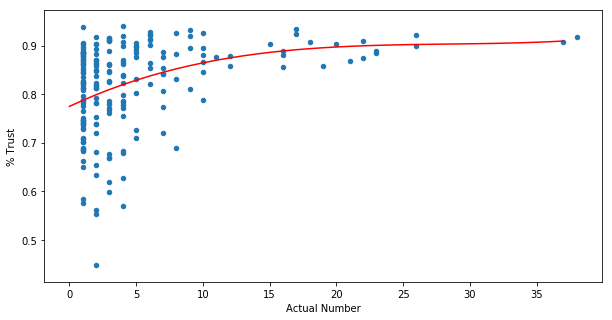

In [24]:
fig3, ax3 = plt.subplots(figsize=(10,5))
demo_comb[demo_comb['Actual Number']>0].plot.scatter('Actual Number', '% Trust', ax=ax3)

z = np.polyfit(demo_comb[demo_comb['Actual Number']>0]['Actual Number'], demo_comb[demo_comb['Actual Number']>0]['% Trust'], 3)
p = np.poly1d(z)
trendX = range(38)
trendy = p(trendX)
plt.plot(trendX, trendy, color='red')

Indeed, it does appear that the probability is lower for smaller demographic groups, whereas it is uniformly high above a threshold between 0.10%-0.15%. It is not clear what this means and it would be stretching the analysis to make any real inferences.

# Conclusions

This analysis has primarily investigated trust in medical advice from the government in the UK, using responses from the Wellcome Global Monitor 2018. Trust in the government is lower than trust in medical workers, such as doctors and nurses. Based on the survey, 41% trust the government for medical advice 'a lot' and 40% trust them 'some'. This leaves almost 18% who trust them 'not much' or 'not at all'. This might be worrying for government organisations seeking to disseminate medical advice.

Of the demographic features identified in the survey, those which were significant in terms of trust levels were age category, household income quintile, subjective income category and employment status. Based on the weighted trust 'scores', the lowest trust was exhibited by the over 50s in the age category, the poorest 20% in household income, those 'finding it hard' in the subjective income category and the unemployed in the employment status category. Also of note is the low score for those in part-time work wanting full-time. Government organisations might wish to target these groups in particular, then, if they hope to increase trust levels.

It is also important not to forget those demographic features which did not have a significant correspondence to trust levels. For example, there was no significant relationship found for religion (religious vs non-religious), gender, education level or area (urban vs rural). 

The multiple variable analysis gave a less clear picture but did provide some insight into the interaction between categories. It was possible to create a logistic regression model that predicted with 82% accuracy whether a respondent exhibited some trust (answered 'a lot' or 'some') or not, based on the four features mentioned. For example, a person in the middle age category, in the middle income quintile, getting by comfortably and employed full-time is 93% likely to exhibit some trust. Conversely, a person in the older age category in the 2nd poorest income quintile and finding it hard to get by and out of the workforce is 69% likely to exhibit trust. This can be used to identify which specific demographic cohorts are less likely to trust the government's medical advice, which is something that government organisations might seek to rectify. It is not within the capacity of this analysis to suggest how that might be done or whether it would be effective.

While this analysis focussed solely on UK findings, the WGM is a global survey. Although trust is higher in the UK than in many other regions, some regions have higher levels of trust in government medical advice. Central Asia and Australia/New Zealand had 86% answer 'a lot' or 'some', compared to the 81% in the UK. It would be interesting to see if this is due to demographic differences or if governments in these regions are able to evoke more trust from certain groups of people.